In [11]:
from IPython.display import Image as ImageDisplay

from markovchain import MarkovChain

BASELINE MATRIX 
           Ttukseom  Gunja  Wangsimni
Ttukseom       0.00   0.54       0.46
Gunja          0.63   0.00       0.37
Wangsimni      0.95   0.05       0.00
./markov_chain__None.jpeg


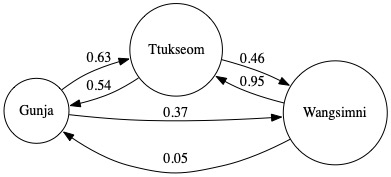

In [12]:
mc = MarkovChain(region_list=['Ttukseom', 'Gunja', 'Wangsimni'],
                 remove_self_flight=True)

base_img = mc.plot_base()
print(base_img)
ImageDisplay(base_img)


 BLOCKED MATRIX BETWEEN Wangsimni AND Gunja
           Ttukseom  Gunja  Wangsimni
Ttukseom        0.0   0.51       0.49
Gunja           1.0   0.00       0.00
Wangsimni       1.0   0.00       0.00


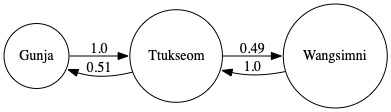

In [5]:
blocked_img = mc.plot_blocked_node(node_1= 'Wangsimni',
                                   node_2='Gunja')
ImageDisplay(blocked_img)

Step: 8
Route:  ['Wangsimni', 'Ttukseom', 'Wangsimni', 'Ttukseom', 'Wangsimni', 'Ttukseom', 'Wangsimni', 'Ttukseom', 'Gunja']


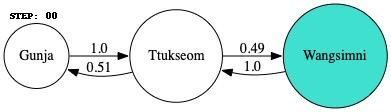

In [9]:
init_region = 'Wangsimni'
dest_region = 'Gunja'
plot_mode = 'blocked'
travel_simulated = mc.travel_simulation(init_region,
                                        dest_region,
                                        plot_mode
                                        )
print(f'Step: {len(travel_simulated)-1}')
print('Route: ',travel_simulated)

travel_img = mc.plot_travel_simulation(plot_mode)
ImageDisplay(travel_img)

# Calculate n-step probability matrix

The UAV is starting the trip from Wangsimni.

What is the probability of ending in Gunja is two trips from now?

In [8]:
mc.prob_ending_region_after_n_step(matrix_df=mc.blocked_df,
                                    init_region='Wangsimni',
                                    final_region='Gunja',
                                    n_step=2)

0.51